In [1]:
import time
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft
import pandas as pd
import seaborn as sns
import math
import sys
import os

In [2]:
start=time.time()

In [3]:
def oversample(image, m):
    "Oversample an image by factor m x m. Simply repeat the pixels"
    # Check inputs
    if np.isnan(image).any():
        print("oversample: nan(s) found in input image")
    result = np.kron(image, np.ones((m,m)))
    # Check output
    if np.isnan(result).any():
        print("oversample: nan(s) found in output image")
    return result

In [4]:
orion=pd.read_table('Orion.csv', delimiter=',')
orion.describe()

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-0.133333,0.300000,0.366667,0.095833,0.525000,0.062500,-0.700000,-0.295833,0.141667,-0.279167,...,-1.654167,-2.845833,-1.891667,-1.308333,-0.825000,-1.041667,-0.633333,-0.166667,0.229167,0.450000
std,0.814898,1.298494,0.995497,1.257492,1.217713,1.553905,2.062291,3.833092,2.790343,2.699272,...,3.067640,2.998692,2.519647,2.137230,2.639376,1.916500,1.313034,0.755079,0.859464,1.595919
min,-3.900000,-2.500000,0.000000,-3.500000,-1.000000,-2.900000,-4.500000,-7.000000,-3.100000,-3.900000,...,-7.400000,-9.100000,-6.400000,-6.000000,-6.100000,-5.100000,-4.600000,-3.700000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,-2.325000,-2.550000,-2.325000,-2.100000,...,-3.150000,-5.000000,-4.725000,-2.625000,-2.200000,-1.925000,-0.175000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.400000,-0.300000,-0.050000,...,-1.900000,-2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.200000,0.925000,0.000000,0.000000,0.125000,1.000000,0.125000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.700000,4.300000,4.600000,3.200000,3.900000,5.100000,3.800000,10.400000,6.900000,8.900000,...,6.800000,1.900000,1.400000,3.100000,7.400000,1.400000,0.500000,0.000000,4.000000,7.000000


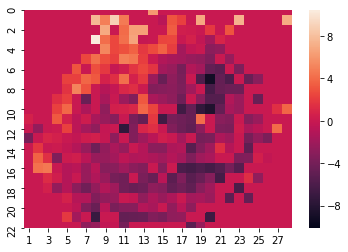

In [5]:
sns.heatmap(orion)
plt.show()

In [6]:
orion_ovrs=oversample((orion.to_numpy()), 2)
#sns.heatmap(orion_ovrs)


In [69]:
df=orion.stack().reset_index().rename(columns={'level_0':'RAdeg', 'level_1':'DEdeg', 0:'RVHalpha'})
df.describe()

,RAdeg,RVHalpha
count,672.000000,672.000000
mean,11.500000,-0.667857
std,6.927343,2.440544
min,0.000000,-10.100000
25%,5.750000,-2.000000
50%,11.500000,0.000000
75%,17.250000,0.000000
max,23.000000,10.400000


In [80]:
m=df.RVHalpha>0
df=df[m]

In [82]:
df.RAdeg=1.0*df.RAdeg

In [105]:
df.DEdeg=pd.to_numeric(df.DEdeg)*1.0

In [106]:
df1 = pd.DataFrame({'RA': df.RAdeg, 'DE': df.DEdeg, 'V': df.RVHalpha, '_key': 1})
df1.describe()

,RA,DE,V,_key
count,112.000000,112.000000,112.000000,112.0
mean,7.794643,11.223214,2.632143,1.0
std,5.002951,6.235195,2.102389,0.0
min,0.000000,1.000000,0.100000,1.0
25%,3.750000,6.000000,0.875000,1.0
50%,7.000000,11.000000,2.200000,1.0
75%,11.250000,14.000000,3.825000,1.0
max,21.000000,28.000000,10.400000,1.0


In [107]:
df2 = df1.copy()

In [108]:
pairs = pd.merge(df1, df2, on='_key', suffixes=('', '_')).drop('_key', 1)
pairs.index = pd.MultiIndex.from_product((df1.index, df2.index))

pairs.head()

RA    DE    V  RA_   DE_   V_
13 13  0.0  14.0  6.1  0.0  14.0  6.1
   35  0.0  14.0  6.1  1.0   8.0  7.6
   36  0.0  14.0  6.1  1.0   9.0  4.9
   37  0.0  14.0  6.1  1.0  10.0  8.9
   38  0.0  14.0  6.1  1.0  11.0  4.7

In [111]:
pairs.loc[:, 'dDE'] =(pairs.DE - pairs.DE_)
pairs.loc[:, 'dRA'] = (pairs.RA - pairs.RA_)*np.cos(np.radians(0.5*(pairs.DE + pairs.DE_)))
pairs.loc[:, 's'] = np.hypot(pairs.dRA, pairs.dDE)
pairs.loc[:, 'log_s'] = np.log10(pairs.s)
pairs.loc[:, 'dV'] = pairs.V - pairs.V_
pairs.loc[:, 'dV2'] = pairs.dV**2
pairs.loc[:, 'log_dV2'] = np.log10(pairs.dV**2)
pairs.loc[:, 'VV_mean'] = 0.5*(pairs.V + pairs.V_)

In [112]:
pairs = pairs[(pairs.dDE > 0.0) & (pairs.dRA > 0.0)]
pairs.head()

,,RA,DE,V,RA_,DE_,V_,dDE,dV,dV2,log_dV2,VV_mean,dRA,s,log_s
43,13,1.0,16.0,3.1,0.0,14.0,6.1,2.0,-3.0,9.00,0.954243,4.60,0.965926,2.221039,0.346556
44,13,1.0,17.0,2.2,0.0,14.0,6.1,3.0,-3.9,15.21,1.182129,4.15,0.963630,3.150966,0.498444
46,13,1.0,19.0,6.8,0.0,14.0,6.1,5.0,0.7,0.49,-0.309804,6.45,0.958820,5.091104,0.706812
50,13,1.0,23.0,7.4,0.0,14.0,6.1,9.0,1.3,1.69,0.227887,6.75,0.948324,9.049824,0.956640
55,13,1.0,28.0,7.0,0.0,14.0,6.1,14.0,0.9,0.81,-0.091515,6.55,0.933580,14.031093,1.147092


In [113]:
pairs.describe()

,RA,DE,V,RA_,DE_,V_,dDE,dV,dV2,log_dV2,VV_mean,dRA,s,log_s
count,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000,1825.000000
mean,10.644384,16.744110,1.772055,5.399452,9.646027,3.560712,7.098082,-1.788658,9.866844,-inf,2.666384,5.064336,9.448450,0.884864
std,4.135467,6.396678,1.414209,3.634915,3.813881,2.400559,5.803122,2.582867,16.043079,NaN,1.487795,3.413803,5.663929,0.298034
min,1.000000,2.000000,0.100000,0.000000,1.000000,0.100000,1.000000,-10.300000,0.000000,-inf,0.100000,0.920505,1.370166,0.136773
25%,8.000000,13.000000,0.500000,2.000000,8.000000,1.900000,2.000000,-3.200000,0.810000,-0.091515,1.550000,1.972571,4.935994,0.693375
50%,11.000000,15.000000,1.400000,5.000000,10.000000,3.000000,5.000000,-1.600000,3.610000,0.557507,2.400000,4.683361,8.058102,0.906233
75%,13.000000,23.000000,2.500000,7.000000,12.000000,4.900000,11.000000,-0.100000,11.560000,1.062958,3.500000,7.517541,13.824609,1.140653
max,21.000000,28.000000,7.400000,18.000000,23.000000,10.400000,26.000000,4.000000,106.090000,2.025674,7.800000,16.073816,26.018099,1.415276


In [114]:
pairs.corr()

,RA,DE,V,RA_,DE_,V_,dDE,dV,dV2,log_dV2,VV_mean,dRA,s,log_s
RA,1.000000,0.203084,-0.357782,0.581915,-0.147061,-0.428587,0.320506,0.202438,-0.194546,-0.221939,-0.515806,0.566701,0.502645,0.515369
DE,0.203084,1.000000,0.131800,-0.126159,0.446524,-0.091338,0.808821,0.157056,-0.062982,-0.043053,-0.011046,0.341140,0.813761,0.753547
V,-0.357782,0.131800,1.000000,-0.235031,0.111481,0.160751,0.072014,0.398130,-0.142619,-0.077865,0.604956,-0.181561,-0.014553,-0.058338
RA_,0.581915,-0.126159,-0.235031,1.000000,-0.496630,-0.603306,0.187328,0.432034,-0.383135,-0.423159,-0.598420,-0.339710,0.047617,0.005047
DE_,-0.147061,0.446524,0.111481,-0.496630,1.000000,0.049583,-0.165017,0.014956,0.015174,0.072239,0.092985,0.314586,-0.029104,0.015460
V_,-0.428587,-0.091338,0.160751,-0.603306,0.049583,1.000000,-0.133267,-0.841399,0.778127,0.656212,0.883151,0.122520,-0.074503,-0.057647
dDE,0.320506,0.808821,0.072014,0.187328,-0.165017,-0.133267,1.000000,0.163291,-0.079396,-0.094957,-0.073287,0.169283,0.916122,0.820461
dV,0.202438,0.157056,0.398130,0.432034,0.014956,-0.841399,0.163291,1.000000,-0.801292,-0.650328,-0.489580,-0.213283,0.061276,0.021635
dV2,-0.194546,-0.062982,-0.142619,-0.383135,0.015174,0.778127,-0.079396,-0.801292,1.000000,0.668381,0.559972,0.169873,0.000136,0.031572
log_dV2,-0.221939,-0.043053,-0.077865,-0.423159,0.072239,0.656212,-0.094957,-0.650328,0.668381,1.000000,0.493638,0.176866,-0.013351,0.010242


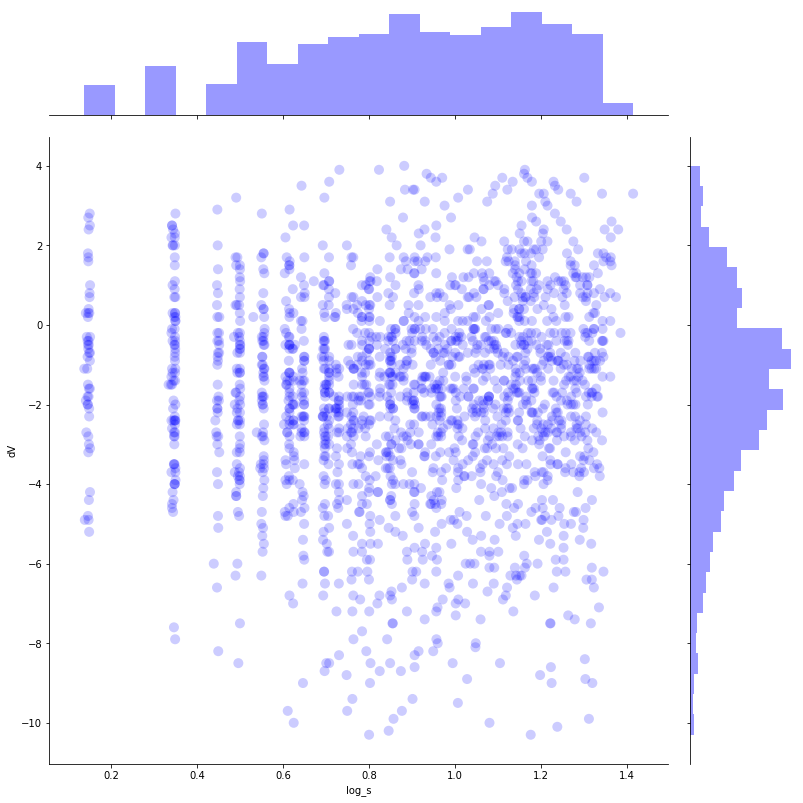

In [118]:
mask = (pairs.log_s > 0) & (pairs.log_dV2 > -4)
ax = sns.jointplot(x='log_s', y='dV', data=pairs[mask], alpha=0.2, s=100, edgecolor='none',color="blue")
ax.fig.set_size_inches(12, 12)

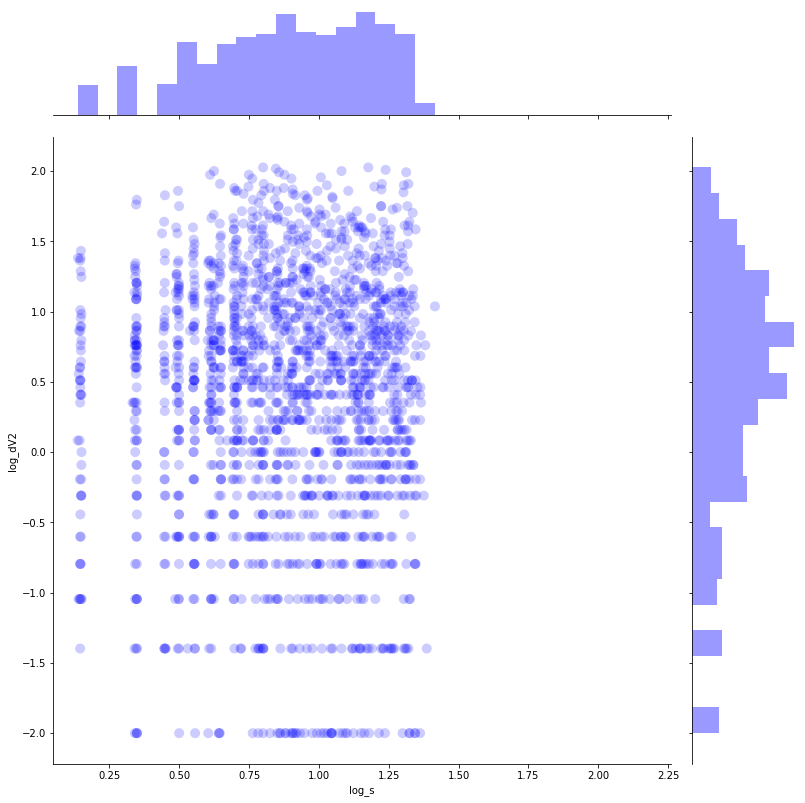

In [119]:
mask = (pairs.log_s > 0) & (pairs.log_dV2 > -4)
ax = sns.jointplot(x='log_s', y='log_dV2', data=pairs[mask], alpha=0.2, s=100, edgecolor='none', color="blue", xlim=[0.05, 2.26])
ax.fig.set_size_inches(12, 12)

In [120]:
pairs.loc[:, 's_class'] = pd.Categorical((2*pairs.log_s + 0.5).astype('int'), ordered=True)
pairs.s_class[pairs.s_class == 0] = 1

In [121]:
for j in range(5):
    print()
    print("s_class =", j)
    print(pairs[pairs.s_class == j][['dV2', 'log_s']].describe())


s_class = 0
       dV2  log_s
count  0.0    0.0
mean   NaN    NaN
std    NaN    NaN
min    NaN    NaN
25%    NaN    NaN
50%    NaN    NaN
75%    NaN    NaN
max    NaN    NaN

s_class = 1
              dV2       log_s
count  586.000000  586.000000
mean     8.603532    0.531157
std     13.911994    0.168107
min      0.000000    0.136773
25%      0.810000    0.446800
50%      3.805000    0.555323
75%     10.240000    0.649450
max    100.000000    0.749276

s_class = 2
               dV2        log_s
count  1039.000000  1039.000000
mean     10.781809     1.003922
std      17.189785     0.146599
min       0.000000     0.750462
25%       0.810000     0.875534
50%       3.610000     1.004737
75%      12.250000     1.139713
max     106.090000     1.249814

s_class = 3
              dV2       log_s
count  200.000000  200.000000
mean     8.815100    1.302719
std     15.448938    0.032710
min      0.000000    1.250484
25%      0.810000    1.276068
50%      2.560000    1.303385
75%      9.767500 

/home/zalenovo/my_project_dir/my_project_env/lib/python3.6/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


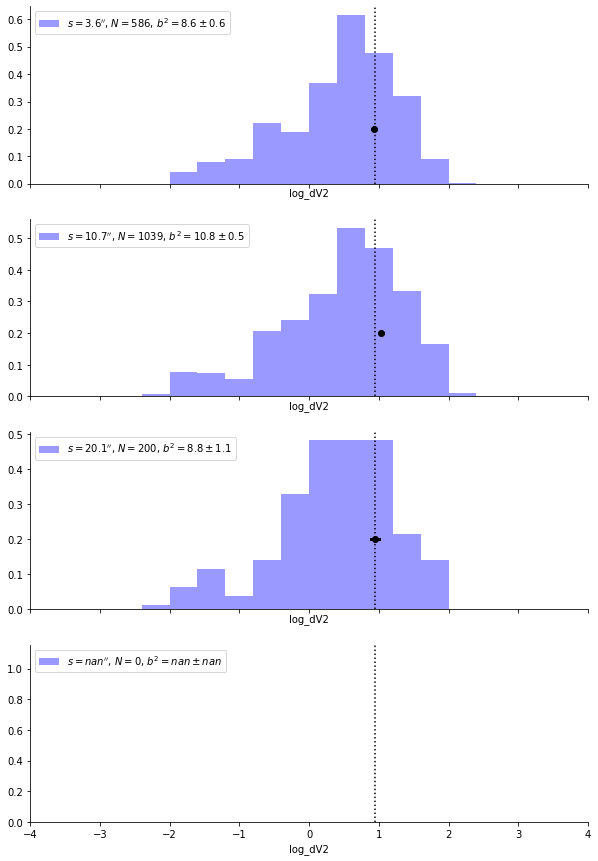

In [122]:
sig2 = pairs.dV2.mean()
sig2a = 2*np.var(df1.V)
fig, axes = plt.subplots(4, 1, figsize=(10, 15), sharex=True)
for sclass, ax in zip(range(1, 5), axes):
    b2mean = np.mean(pairs.dV2[pairs.s_class == sclass])
    b2std = np.std(pairs.dV2[pairs.s_class == sclass])
    b2mean2 = np.mean(pairs.log_dV2[pairs.s_class == sclass])
    n = np.sum(pairs.s_class == sclass)
    b2sem = b2std/np.sqrt(n)
    smean = np.mean(10**pairs.log_s[pairs.s_class == sclass])
    label = f"$s = {smean:.1f}''$"
    label += f", $N = {n}$"
    label += fr", $b^2 = {b2mean:.1f} \pm {b2sem:.1f}$"
    sns.distplot(pairs.log_dV2[pairs.s_class == sclass], 
                 norm_hist=True, kde=False, ax=ax,
                 label=label, bins=20, color="blue",hist_kws=dict(range=[-4.0, 4.0])
                )
    ax.plot([np.log10(b2mean)], [0.2], 'o', color='k')
    ax.plot([np.log10(b2mean - b2sem), np.log10(b2mean + b2sem)], [0.2]*2, lw=3, color='k')
    ax.axvline(np.log10(sig2a), color='k', ls=':')
    ax.set(xlim=[-4.0, 4.0])
    ax.legend(loc='upper left')
sns.despine()

In [123]:
print(f'Dotted line is 2 x sigma^2 = {sig2a:.2f}')

Dotted line is 2 x sigma^2 = 8.76


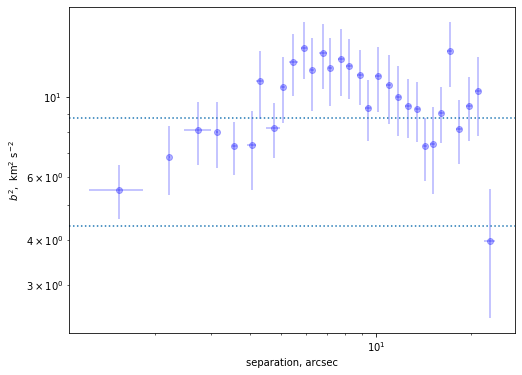

In [131]:
ngroup = 60
groups = np.arange(len(pairs)) // ngroup
table = pairs[['s', 'dV2']].sort_values('s').groupby(groups).describe()
fig, ax = plt.subplots(figsize=(8, 6))
s = table[('s', 'mean')]
e_s = table[('s', 'std')]
b2 = table[('dV2', 'mean')]
ng = table[('dV2', 'count')]
e_b2 = table[('dV2', 'std')]/np.sqrt(ng - 1)
ax.axhline(sig2a, ls=':')
ax.axhline(0.5*sig2a, ls=':')
ax.errorbar(s, b2, yerr=e_b2, xerr=e_s, fmt='o', alpha=0.3, color="blue")
#sgrid = np.logspace(0.3, 1.65)
#ax.plot(sgrid, 38.5*sgrid**(0.8), color="k", lw=0.5)
ax.set(xscale='log', yscale='log', 
       xlabel='separation, arcsec',
       ylabel=r'$b^2,\ \mathrm{km^2\ s^{-2}}$'
      )
None

In [ ]:
finish=time.time()
print("Runnig time:",finish-start, "seconds" )